# Catastrophic forgetting example over 4 tasks

In [22]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
import numpy as np
import random

Adapted from Original Pytorch github https://github.com/pytorch/examples/blob/main/mnist/main.py 

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0.0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        total_loss += loss.item()

        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()


        loss.backward()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

    # Calculate and return the average loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100.*correct / len(train_loader.dataset)
    return accuracy, average_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return accuracy, test_loss

def train_and_test(args, model, device, train_loader, test_loader, optimizer, scheduler, title = ""):
    train_losses = []  # Store training losses
    test_accuracies = []  # Store test accuracies
    test_losses = [] 
    train_accuracies = [] 

    for epoch in range(1, args.epochs + 1):
        train_accuracy, train_loss = train(args, model, device, train_loader, optimizer, epoch)
        test_accuracy, test_loss = test(model, device, test_loader)
        scheduler.step()

        
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)

            # Print training loss and test accuracy during each epoch
        print(f'Epoch {epoch}/{args.epochs}: Training Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
        
    # Plot loss and accuracy after all epochs
    plot_loss_and_accuracy(train_accuracies, train_losses, test_accuracies, test_losses, title)

def save_model_state_dict(model_state_dict, filename, overwrite=True):
    models_folder = "models"
    
    # Check if the models folder exists, if not, create it
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)

    file_path = os.path.join(models_folder, filename)

    # Check if the file already exists
    if os.path.exists(file_path) and not overwrite:
        user_input = input(f"The file '{filename}' already exists. Do you want to overwrite it? (yes/no): ")
        if user_input.lower() != 'yes':
            print("Model not saved.")
            return

    # Save the model state dict
    torch.save(model_state_dict, file_path)
    print(f"Model state dict saved to: {file_path}")
def plot_loss_and_accuracy(train_accuracies, train_losses, test_accuracies, test_losses, title=""):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

    # Plot Training Loss and Accuracy
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(train_accuracies, label='Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_title(f'{title} - Training Data')
    ax1.legend()

    # Plot Testing Loss and Accuracy
    ax2.plot(test_losses, label='Testing Loss')
    ax2.plot(test_accuracies, label='Testing Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_title(f'{title} - Testing Data')
    ax2.legend()

    # Calculate % change in accuracy between train and test
    train_accuracies = np.array(train_accuracies)
    test_accuracies = np.array(test_accuracies)
    percentage_change = np.abs((train_accuracies - test_accuracies) / train_accuracies * 100)

    # Plot % change
    ax3.plot(percentage_change, label='% Change')
    ax3.set_xlabel('Epoch')
    ax3.set_title(f'{title} - % Change in Accuracy')
    ax3.legend()

    plt.tight_layout()
    plt.show()

def plot_loss_and_accuracy_simple(train_accuracies, train_losses, test_accuracies, test_losses, title = ""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Training Loss and Accuracy
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(train_accuracies, label='Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_title(f'{title} - training data')
    ax1.legend()

    # Plot Testing Loss and Accuracy
    ax2.plot(test_losses, label='Testing Loss')
    ax2.plot(test_accuracies, label='Testing Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_title(f'{title} - testing data')
    ax2.legend()

    
def get_data_loaders(dataset, train_size, test_size, train_kwargs, test_kwargs):
    train_set, test_set = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_set, **train_kwargs)
    test_loader = DataLoader(test_set, **test_kwargs)
    return train_loader, test_loader

def get_scenario_labels():
    # Define scenarios with different sets of labels
    scenarios = [
        [5, 6, 7, 8, 9, 1],
        [2, 6, 3, 8, 9, 1]
        # Add more scenarios as needed
    ]

    # Randomly select a scenario
    selected_scenario = random.choice(scenarios)

    return selected_scenario

def run_scenario(args, optimizer_taskN, scheduler_taskN, model, device, train_kwargs, test_kwargs, scenario, title_prefix="Task", transform=None):
    mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

    if args.test_reduced:
        sampled_indices = torch.randperm(len(mnist_dataset))[:1000]
        mnist_dataset = Subset(mnist_dataset, sampled_indices)

    scenario_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in scenario]

    train_size = int(0.8 * len(scenario_indices))
    test_size = len(scenario_indices) - train_size

    train_loader, test_loader = get_data_loaders(
        Subset(mnist_dataset, scenario_indices), train_size, test_size, train_kwargs, test_kwargs
    )

    # reuse task 1 optimizer and scheduler
    optimizer = optimizer_taskN
    scheduler = scheduler_taskN

    train_and_test(args, model, device, train_loader, test_loader, optimizer, scheduler, title=f"{title_prefix}: ")
    model_state_dict = model.state_dict()
    save_model_state_dict(model_state_dict, f"mnist_cnn_{title_prefix.lower()}.pt")
    return f"mnist_cnn_{title_prefix.lower()}.pt"



In [24]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
parser.add_argument('--test_reduced', action='store_true', default=False,
                        help='For Saving the current Model')


args, unknown = parser.parse_known_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()
    
torch.manual_seed(args.seed)

if use_cuda:
        device = torch.device("cuda")
elif use_mps:
        device = torch.device("mps")
else:
        device = torch.device("cpu")

Train Epoch: 1 [0/29236 (0%)]	Loss: 1.620534
Train Epoch: 1 [640/29236 (2%)]	Loss: 0.485315
Train Epoch: 1 [1280/29236 (4%)]	Loss: 0.211582
Train Epoch: 1 [1920/29236 (7%)]	Loss: 0.129892
Train Epoch: 1 [2560/29236 (9%)]	Loss: 0.110819
Train Epoch: 1 [3200/29236 (11%)]	Loss: 0.086438
Train Epoch: 1 [3840/29236 (13%)]	Loss: 0.067602
Train Epoch: 1 [4480/29236 (15%)]	Loss: 0.050723
Train Epoch: 1 [5120/29236 (18%)]	Loss: 0.059049
Train Epoch: 1 [5760/29236 (20%)]	Loss: 0.041223
Train Epoch: 1 [6400/29236 (22%)]	Loss: 0.034861
Train Epoch: 1 [7040/29236 (24%)]	Loss: 0.006323
Train Epoch: 1 [7680/29236 (26%)]	Loss: 0.009950
Train Epoch: 1 [8320/29236 (28%)]	Loss: 0.092527
Train Epoch: 1 [8960/29236 (31%)]	Loss: 0.057528
Train Epoch: 1 [9600/29236 (33%)]	Loss: 0.086590
Train Epoch: 1 [10240/29236 (35%)]	Loss: 0.022528
Train Epoch: 1 [10880/29236 (37%)]	Loss: 0.020158
Train Epoch: 1 [11520/29236 (39%)]	Loss: 0.003577
Train Epoch: 1 [12160/29236 (42%)]	Loss: 0.181705
Train Epoch: 1 [12800/292

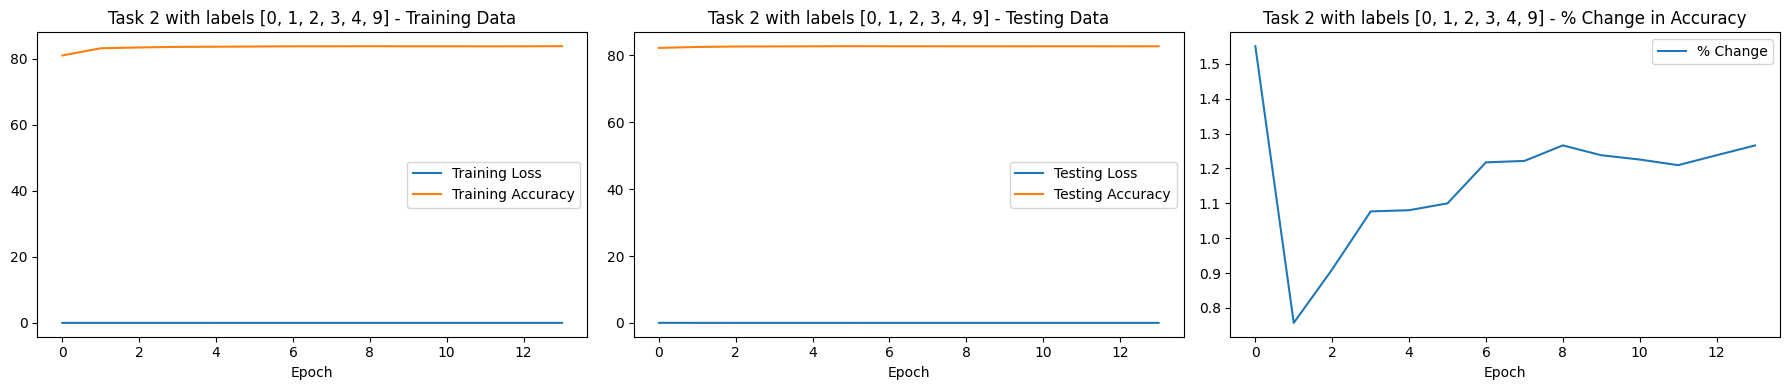

Model state dict saved to: models/mnist_cnn_task1.pt


In [25]:
# Set up common configurations
train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if 'cuda' in str(device):
    cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

if args.test_reduced:
        sampled_indices = torch.randperm(len(mnist_dataset))[:1000]
        mnist_dataset = Subset(mnist_dataset, sampled_indices)

# Define task 1 labeling
task1_classes = [0, 1, 2, 3, 4, 9]
task1_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in task1_classes]
task1_dataset = Subset(mnist_dataset, task1_indices)

train_size_task1 = int(0.8 * len(task1_indices))
test_size_task1 = len(task1_indices) - train_size_task1

train_loader_task1, test_loader_task1 = get_data_loaders(task1_dataset, train_size_task1, test_size_task1,
                                                             train_kwargs, test_kwargs)
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
train_and_test(args, model, device, train_loader_task1, test_loader_task1, optimizer, scheduler,title=f"Task 2 with labels {task1_classes}")
model_state_dict_task1 = model.state_dict()
save_model_state_dict(model_state_dict_task1, "mnist_cnn_task1.pt")


# Testing on 4 different tasks 
While it's not strictly necessary for the second model to use the exact same optimizer and scheduler parameters as the first model, there are benefits to doing so. When you use the same optimizer and scheduler parameters, it helps ensure a more consistent training environment for both tasks, which can contribute to mitigating catastrophic forgetting.

Here are some considerations:

Optimizer Parameters:

Using the same optimizer helps maintain continuity in the optimization process. If the first model was trained with a specific optimizer, reusing it for the second model can help preserve some knowledge acquired during the training of the first task.
However, it's not a strict requirement. You can experiment with different optimizers or learning rates for the second task. Some techniques, like Elastic Weight Consolidation (EWC), specifically adjust the optimizer to prioritize the preservation of important parameters from the first task.
Scheduler Parameters:

The scheduler adjusts the learning rate during training, and using the same scheduler parameters can help ensure similar learning rate schedules for both tasks.
If you observe that the learning rate needs to be adjusted for the second task, you can experiment with different scheduling strategies.

Train Epoch: 1 [0/29239 (0%)]	Loss: 0.000239
Train Epoch: 1 [640/29239 (2%)]	Loss: 0.053021
Train Epoch: 1 [1280/29239 (4%)]	Loss: 0.000020
Train Epoch: 1 [1920/29239 (7%)]	Loss: 0.000019
Train Epoch: 1 [2560/29239 (9%)]	Loss: 0.000002
Train Epoch: 1 [3200/29239 (11%)]	Loss: 0.074008
Train Epoch: 1 [3840/29239 (13%)]	Loss: 0.001284
Train Epoch: 1 [4480/29239 (15%)]	Loss: 0.000174
Train Epoch: 1 [5120/29239 (18%)]	Loss: 0.000973
Train Epoch: 1 [5760/29239 (20%)]	Loss: 0.016703
Train Epoch: 1 [6400/29239 (22%)]	Loss: 0.000071
Train Epoch: 1 [7040/29239 (24%)]	Loss: 0.000016
Train Epoch: 1 [7680/29239 (26%)]	Loss: 0.000501
Train Epoch: 1 [8320/29239 (28%)]	Loss: 0.005600
Train Epoch: 1 [8960/29239 (31%)]	Loss: 0.000088
Train Epoch: 1 [9600/29239 (33%)]	Loss: 0.000035
Train Epoch: 1 [10240/29239 (35%)]	Loss: 0.020294
Train Epoch: 1 [10880/29239 (37%)]	Loss: 0.000001
Train Epoch: 1 [11520/29239 (39%)]	Loss: 0.001483
Train Epoch: 1 [12160/29239 (42%)]	Loss: 0.000996
Train Epoch: 1 [12800/292

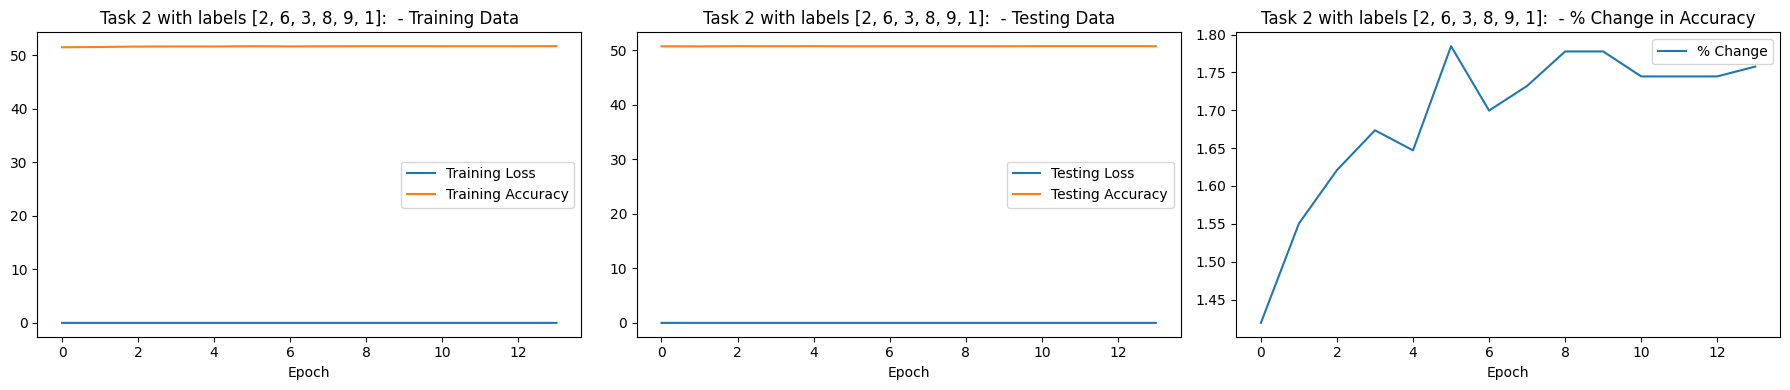

Model state dict saved to: models/mnist_cnn_task 2 with labels [2, 6, 3, 8, 9, 1].pt
Train Epoch: 1 [0/28916 (0%)]	Loss: 2.978394
Train Epoch: 1 [640/28916 (2%)]	Loss: 2.054033
Train Epoch: 1 [1280/28916 (4%)]	Loss: 3.654945
Train Epoch: 1 [1920/28916 (7%)]	Loss: 2.792486
Train Epoch: 1 [2560/28916 (9%)]	Loss: 1.818243
Train Epoch: 1 [3200/28916 (11%)]	Loss: 2.829002
Train Epoch: 1 [3840/28916 (13%)]	Loss: 2.840770
Train Epoch: 1 [4480/28916 (15%)]	Loss: 2.532468
Train Epoch: 1 [5120/28916 (18%)]	Loss: 2.588831
Train Epoch: 1 [5760/28916 (20%)]	Loss: 1.751267
Train Epoch: 1 [6400/28916 (22%)]	Loss: 0.804601
Train Epoch: 1 [7040/28916 (24%)]	Loss: 0.758275
Train Epoch: 1 [7680/28916 (27%)]	Loss: 0.899263
Train Epoch: 1 [8320/28916 (29%)]	Loss: 1.445869
Train Epoch: 1 [8960/28916 (31%)]	Loss: 1.546498
Train Epoch: 1 [9600/28916 (33%)]	Loss: 1.144835
Train Epoch: 1 [10240/28916 (35%)]	Loss: 0.951706
Train Epoch: 1 [10880/28916 (38%)]	Loss: 1.354957
Train Epoch: 1 [11520/28916 (40%)]	Loss:

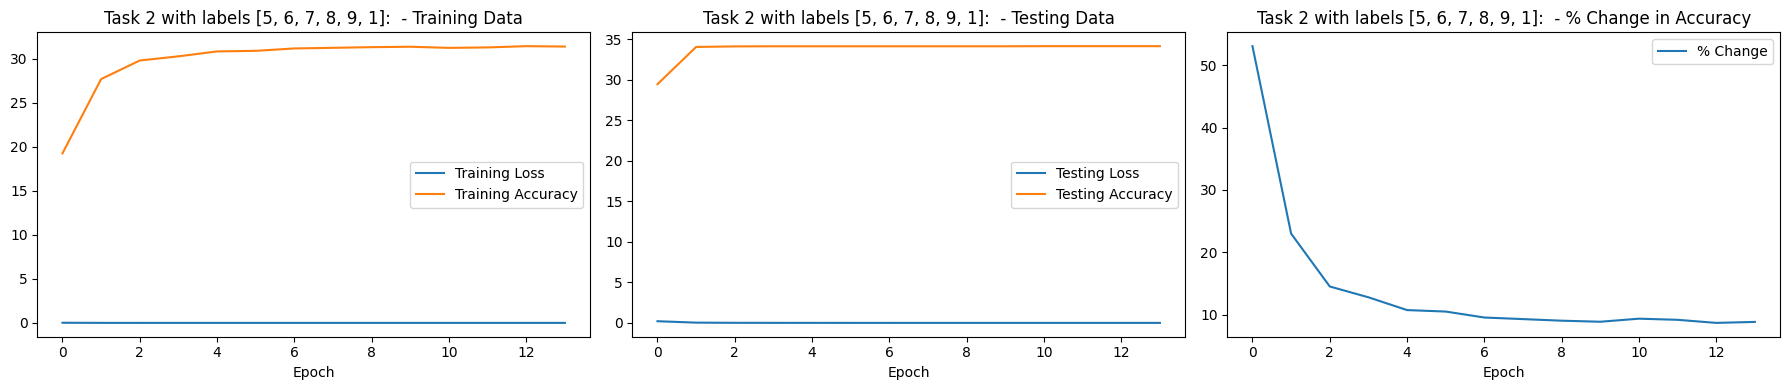

Model state dict saved to: models/mnist_cnn_task 2 with labels [5, 6, 7, 8, 9, 1].pt
Train Epoch: 1 [0/28916 (0%)]	Loss: 0.052374
Train Epoch: 1 [640/28916 (2%)]	Loss: 0.053944
Train Epoch: 1 [1280/28916 (4%)]	Loss: 0.080450
Train Epoch: 1 [1920/28916 (7%)]	Loss: 0.062614
Train Epoch: 1 [2560/28916 (9%)]	Loss: 0.030013
Train Epoch: 1 [3200/28916 (11%)]	Loss: 0.020413
Train Epoch: 1 [3840/28916 (13%)]	Loss: 0.042671
Train Epoch: 1 [4480/28916 (15%)]	Loss: 0.075415
Train Epoch: 1 [5120/28916 (18%)]	Loss: 0.178260
Train Epoch: 1 [5760/28916 (20%)]	Loss: 0.039372
Train Epoch: 1 [6400/28916 (22%)]	Loss: 0.051173
Train Epoch: 1 [7040/28916 (24%)]	Loss: 0.085619
Train Epoch: 1 [7680/28916 (27%)]	Loss: 0.098479
Train Epoch: 1 [8320/28916 (29%)]	Loss: 0.050834
Train Epoch: 1 [8960/28916 (31%)]	Loss: 0.025385
Train Epoch: 1 [9600/28916 (33%)]	Loss: 0.069290
Train Epoch: 1 [10240/28916 (35%)]	Loss: 0.035844
Train Epoch: 1 [10880/28916 (38%)]	Loss: 0.019715
Train Epoch: 1 [11520/28916 (40%)]	Loss:

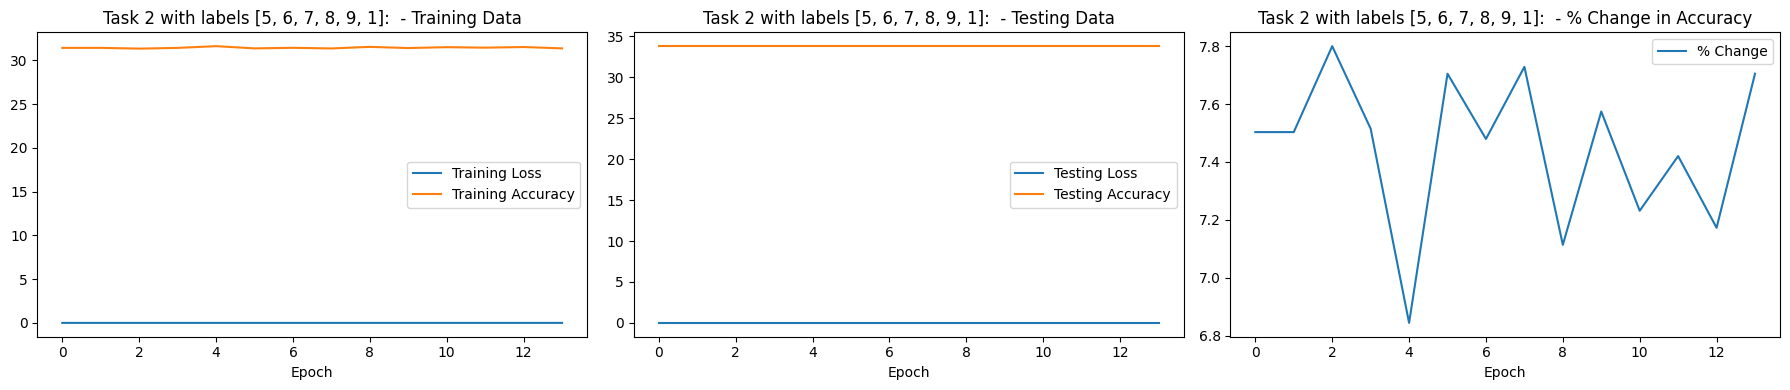

Model state dict saved to: models/mnist_cnn_task 2 with labels [5, 6, 7, 8, 9, 1].pt
Train Epoch: 1 [0/28916 (0%)]	Loss: 0.056969
Train Epoch: 1 [640/28916 (2%)]	Loss: 0.035272
Train Epoch: 1 [1280/28916 (4%)]	Loss: 0.019132
Train Epoch: 1 [1920/28916 (7%)]	Loss: 0.044780
Train Epoch: 1 [2560/28916 (9%)]	Loss: 0.079312
Train Epoch: 1 [3200/28916 (11%)]	Loss: 0.072005
Train Epoch: 1 [3840/28916 (13%)]	Loss: 0.041776
Train Epoch: 1 [4480/28916 (15%)]	Loss: 0.045956
Train Epoch: 1 [5120/28916 (18%)]	Loss: 0.090371
Train Epoch: 1 [5760/28916 (20%)]	Loss: 0.084454
Train Epoch: 1 [6400/28916 (22%)]	Loss: 0.018431
Train Epoch: 1 [7040/28916 (24%)]	Loss: 0.122757
Train Epoch: 1 [7680/28916 (27%)]	Loss: 0.020006
Train Epoch: 1 [8320/28916 (29%)]	Loss: 0.035639
Train Epoch: 1 [8960/28916 (31%)]	Loss: 0.063627
Train Epoch: 1 [9600/28916 (33%)]	Loss: 0.016904
Train Epoch: 1 [10240/28916 (35%)]	Loss: 0.039839
Train Epoch: 1 [10880/28916 (38%)]	Loss: 0.064268
Train Epoch: 1 [11520/28916 (40%)]	Loss:

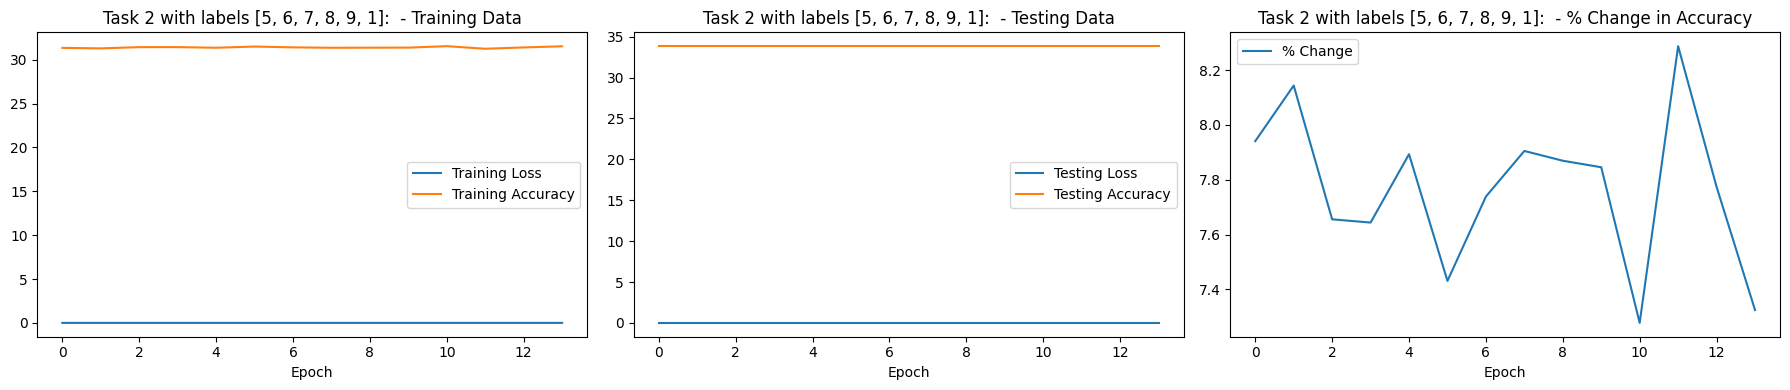

Model state dict saved to: models/mnist_cnn_task 2 with labels [5, 6, 7, 8, 9, 1].pt


In [26]:
model_taskN = Net().to(device)
# load the weights from model trained on task 1
model_taskN.load_state_dict(model_state_dict_task1.copy()) 
optimizer_taskN = optim.Adadelta(model_taskN.parameters(), lr=args.lr)
scheduler_taskN = StepLR(optimizer_taskN, step_size=1, gamma=args.gamma)

for i in range(4):
    # Get scenario labels for each iteration
    scenario_labels_i = get_scenario_labels()

    run_scenario(args,optimizer_taskN,scheduler_taskN, model_taskN, device, train_kwargs, test_kwargs, scenario_labels_i, transform=transform, title_prefix=f"Task 2 with labels {scenario_labels_i}")
